In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-price-prediction-dataset/used_cars.csv


In [107]:
import sys
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [108]:
df = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv') 

In [109]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [110]:
age = df['model_year'].max() - df['model_year']
age.head()

0    11
1     3
2     2
3     9
4     3
Name: model_year, dtype: int64

In [111]:
df['milage'].head()

0    51,000 mi.
1    34,742 mi.
2    22,372 mi.
3    88,900 mi.
4     9,835 mi.
Name: milage, dtype: object

In [112]:
milage = df['milage']
milage = milage.str.replace(",", "")
milage = milage.str.replace("mi.", "")
milage = milage.astype(int)
milage.head()

0    51000
1    34742
2    22372
3    88900
4     9835
Name: milage, dtype: int64

In [113]:
print(milage.apply(type).unique())

[<class 'int'>]


In [114]:
df['price'].head()

0    $10,300
1    $38,005
2    $54,598
3    $15,500
4    $34,999
Name: price, dtype: object

In [115]:
price = df['price']
price = price.str.replace(",", "")
price = price.str.replace("$", "")
price = price.astype(int)
price.head()

0    10300
1    38005
2    54598
3    15500
4    34999
Name: price, dtype: int64

In [116]:
print(price.apply(type).unique())

[<class 'int'>]


In [117]:
# accident is categorical variable
df['accident'].value_counts()

accident
None reported                             2910
At least 1 accident or damage reported     986
Name: count, dtype: int64

In [123]:
accident_free = df['accident'] == 'None reported'
accident_free = accident_free.astype(int)

In [125]:
# Preparation training data X
X = torch.column_stack([
    torch.tensor(age.values, dtype = torch.float32),
    torch.tensor(milage.values, dtype = torch.float32),
    torch.tensor(accident_free.values, dtype = torch.float32)
])
X

tensor([[1.1000e+01, 5.1000e+04, 0.0000e+00],
        [3.0000e+00, 3.4742e+04, 0.0000e+00],
        [2.0000e+00, 2.2372e+04, 1.0000e+00],
        ...,
        [2.0000e+00, 2.1160e+03, 1.0000e+00],
        [4.0000e+00, 3.3000e+04, 1.0000e+00],
        [4.0000e+00, 4.3000e+04, 0.0000e+00]])

In [126]:
print(f"age type: {type(age)}, age shape: {age.shape if hasattr(age, 'shape') else 'no shape'}")
print(f"milage type: {type(milage)}, milage shape: {milage.shape if hasattr(milage, 'shape') else 'no shape'}")
print(f"accident free type: {type(accident_free)}, accident free shape: {accident_free.shape if hasattr(accident_free, 'shape') else 'no shape'}")

age type: <class 'pandas.core.series.Series'>, age shape: (4009,)
milage type: <class 'pandas.core.series.Series'>, milage shape: (4009,)
accident free type: <class 'pandas.core.series.Series'>, accident free shape: (4009,)


In [128]:
#print(age.apply(type).unique())
#print(milage.apply(type).unique())
#print(accident_free.apply(type).unique())

In [129]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)
X = (X - x_mean) / x_std
print(x_mean)
print(x_std)

tensor([8.4844e+00, 6.4718e+04, 7.2587e-01])
tensor([6.1048e+00, 5.2297e+04, 4.4613e-01])


In [130]:
# preparation of y data
y = torch.tensor(price, dtype = torch.float32).reshape(-1, 1)

In [131]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [146]:
#model building
model = nn.Linear(3,1)  #2 = number of independent variables and 1 = number of dependent variable
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [147]:
losses = []
for i in range(0, 3000):
    
    #Training Pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(loss.item())
    losses.append(loss.item())

1.353833794593811
1.1777790784835815
1.0834665298461914
1.02720308303833
0.9911230206489563
0.9668511748313904
0.949992835521698
0.9380303025245667
0.9294194579124451
0.9231613874435425
0.918584406375885
0.9152230024337769
0.912747323513031
0.9109210968017578
0.9095718860626221


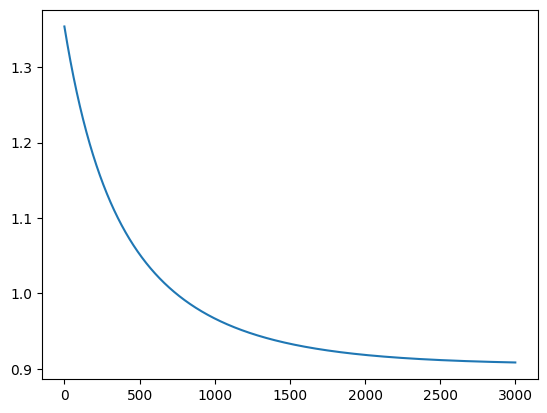

In [148]:
plt.plot(losses)

In [155]:
# do prediction on new data
x_new = torch.tensor([
    [5, 10000, 1],
    [5, 10000, 0]
], dtype = torch.float32)

In [156]:
prediction = model((x_new - x_mean) / x_std)
print(prediction)
print(prediction * y_std + y_mean)

tensor([[0.2997],
        [0.2226]], grad_fn=<AddmmBackward0>)
tensor([[68139.6719],
        [62073.7656]], grad_fn=<AddBackward0>)
